In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.core.kernel.piecewise_library.transforms_nd import piecewise_nd, PiecewiseLinearFunctionND
from pyomo.core.kernel.piecewise_library.util import generate_delaunay
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

import logging
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm as tqdm

In [2]:
def pump_power(dh, q):
    a = 0.033
    b = 0.061
    c = 11.306

    return (a * q ** 2 + b * dh**2 \
        * q + c * q * dh) / 1000  # kWh -> MW

def QH_pump(dh):
    return (-3.9764*(dh)**2 - 17.7244*(dh) + 269.58)

dh = np.arange(0, 6.51, 0.01)
q = np.arange(0, 261, 1)


In [3]:
dh_grid, q_grid = np.meshgrid(dh, q)
power_grid = pump_power(dh_grid, q_grid)

In [4]:
qh_grid = QH_pump(dh_grid)

In [5]:
# Mask the power grid above the qh-line
power_grid_ma = np.ma.masked_where(q_grid > qh_grid, power_grid)


In [6]:
# Now fit a linear model to the pump power
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.vstack([dh_grid.flatten(), q_grid.flatten()]).T
y = power_grid.flatten()

model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [7]:
# Plot the fitted model
dh_fit = np.arange(0, 6.51, 0.01)
q_fit = np.arange(0, 261, 1)
dh_fit_grid, q_fit_grid = np.meshgrid(dh_fit, q_fit)
X_fit = np.vstack([dh_fit_grid.flatten(), q_fit_grid.flatten()]).T
y_fit = model.predict(X_fit).reshape(dh_fit_grid.shape)

y_fit = np.ma.masked_where(q_grid > qh_grid, y_fit)


# fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# ax[0].contourf(dh_grid, q_grid, power_grid_ma, levels=100, cmap='Blues', vmin=0, vmax=8)
# ax[0].plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
# ax[0].set_xlabel('Head [m]')
# ax[0].set_ylabel('Discharge [m$^3$s$^{-1}$]')
# ax[0].set_title('Nonlinear pump power [MW]')
# ax[0].set_ylim(0, 260)

# # cbar = fig.colorbar(ax[1].contourf(dh_grid, q_grid, y_fit, levels=100, cmap='Blues', vmin=0, vmax=8))
# ax[1].contourf(dh_grid, q_grid, y_fit, levels=100, cmap='Blues', vmin=0, vmax=8)
# ax[1].plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
# ax[1].set_xlabel('Head [m]')
# ax[1].set_title('Linear pump power [MW]')
# ax[1].set_ylim(0, 260)


In [72]:
# Now calculate the Delaunay triangulation of the pump power
n_boxes = 3
linegrids = [
    np.linspace(0, 6.5, n_boxes),
    np.linspace(0, 260, n_boxes)
]
points = np.vstack(np.meshgrid(*linegrids)).reshape(2, -1).T
tri = Delaunay(points)

power = pump_power(points[:, 0], points[:, 1])
interp = LinearNDInterpolator(tri, power)

y_interp = interp(X_fit).reshape(power_grid.shape)
y_interp = np.ma.masked_where(q_grid > qh_grid, y_interp)

In [94]:
max(power_grid_ma.flatten())

7.3142559972

In [73]:
# tri.simplices

In [74]:
# class LinearTriangle():
#     def __init__(self, points, values):
#         self.points = points
#         self.values = values

#     def calculate_linearization_(self):
#         # Calculate the linearization of the triangle
#         # First calculate the gradient
        

In [75]:
vertex_indices = tri.simplices

vertex_coordinates = []
derivatives_dh = []
derivatives_q = []
intercepts = []

# For all simplices, calculate the derivatives of the piecewise function
# with respect to the head and discharge
# The derivatives are calculated by calculating the slope for base and height of the triangle
for simplice in tri.simplices:
    # Find the vertices of the triangle
    v1, v2, v3 = simplice

    # Find the coordinates of the vertices
    dh1, q1 = points[v1]
    dh2, q2 = points[v2]
    dh3, q3 = points[v3]

    # Calculate the power (third coordinate)
    p1 = pump_power(dh1, q1)
    p2 = pump_power(dh2, q2)
    p3 = pump_power(dh3, q3)

    # Find out the coefficients and the function of the linearization
    lin_coefs = np.linalg.solve(np.array([[dh1, q1, 1], [dh2, q2, 1], [dh3, q3, 1]]), np.array([p1, p2, p3]))
    derivatives_dh.append(lin_coefs[0])
    derivatives_q.append(lin_coefs[1])
    intercepts.append(lin_coefs[2])



In [76]:
def find_simplex_index(q, dh):
    # Find the index of the simplex that contains the point (q, dh)
    # We do this manually, without the find_simplex function of the Delaunay object

    # Find the triangle that contains the point
    for i, simplex in enumerate(tri.simplices):
        # Find the vertices of the triangle
        v1, v2, v3 = simplex

        # Find the coordinates of the vertices
        dh1, q1 = points[v1]
        dh2, q2 = points[v2]
        dh3, q3 = points[v3]

        # Calculate the barycentric coordinates of the point
        alpha = ((q2 - q3) * (dh - dh3) + (dh3 - dh2) * (q - q3)) / ((q2 - q3) * (dh1 - dh3) + (dh3 - dh2) * (q1 - q3))
        beta = ((q3 - q1) * (dh - dh3) + (dh1 - dh3) * (q - q3)) / ((q2 - q3) * (dh1 - dh3) + (dh3 - dh2) * (q1 - q3))
        gamma = 1.0 - alpha - beta

        # alpha, beta, gamma = tri.transform[i,:2].dot(np.array([dh, q]) - tri.transform[i,2])


        # Check if the point is inside the triangle
        if alpha > 0 and beta > 0 and gamma > 0:
            return i

In [111]:
alpha = []
beta = []
gamma = []

for i, simplex in enumerate(tqdm(tri.simplices)):        
        # Find the vertices of the triangle
        v1, v2, v3 = simplex

        # Find the coordinates of the vertices
        dh1, q1 = points[v1]
        dh2, q2 = points[v2]
        dh3, q3 = points[v3]

        # alphas = [((q2 - q3) * (dh - dh3) + (dh3 - dh2) * (q - q3)) / ((q2 - q3) * (dh1 - dh3) + (dh3 - dh2) * (q1 - q3)) for dh in np.arange(0, 6.51, 0.01) for q in np.arange(0, 261, 1)]
        # betas = [((q3 - q1) * (dh - dh3) + (dh1 - dh3) * (q - q3)) / ((q2 - q3) * (dh1 - dh3) + (dh3 - dh2) * (q1 - q3)) for dh in np.arange(0, 6.51, 0.01) for q in np.arange(0, 261, 1)]
        # gammas = [1.0 - alphas[k] - betas[k] for k in range(len(alphas))]
        alphas=[]
        betas=[]
        gammas=[]

        for dh in np.arange(0, 6.51, 0.1):
             for q in np.arange(0, 261, 1):
                
                alpha_ = dh1 * (q3 - q1) + (q - q1) * (dh3 - dh1) - dh * (q3 - q1)
                beta_ = (q - q1 - (alpha_ * (q2 - q1))) / (q3 - q1)
                gamma_ = 1 - alpha_ - beta_
                if np.isinf(alpha_) or np.isinf(beta_) or np.isinf(gamma_):
                    # Try from point 2
                    # print('Zero division error')
                    alpha_ = dh2 * (q3 - q2) + (q - q2) * (dh3 - dh2) - dh * (q3 - q2)
                    beta_ = (q - q2 - (alpha_ * (q1 - q2))) / (q3 - q2)
                    gamma_ = 1 - alpha_ - beta_
                    if np.isinf(alpha_) or np.isinf(beta_) or np.isinf(gamma_):
                        # Try from point 3
                        # print('Zero division error')
                        alpha_ = dh3 * (q2 - q3) + (q - q3) * (dh2 - dh3) - dh * (q2 - q3)
                        beta_ = (q - q3 - (alpha_ * (q1 - q3))) / (q2 - q3)
                        gamma_ = 1 - alpha_ - beta_
                        if np.isinf(alpha_) or np.isinf(beta_) or np.isinf(gamma_):
                            assert False, 'Zero division error'

                alphas.append(alpha_)
                betas.append(beta_)
                gammas.append(gamma_)

        # Calculate the barycentric coordinates of the point
        alpha += alphas
        beta += betas
        gamma += gammas

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\Heijden\AppData\Local\Temp\ipykernel_17200\3642539783.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  beta_ = (q - q1 - (alpha_ * (q2 - q1))) / (q3 - q1)
C:\Users\Heijden\AppData\Local\Temp\ipykernel_17200\3642539783.py:25: RuntimeWarning: invalid value encountered in scalar divide
  beta_ = (q - q1 - (alpha_ * (q2 - q1))) / (q3 - q1)
100%|██████████| 8/8 [00:00<00:00, 14.15it/s]


In [112]:
print(f'max alpha: {min(alpha)}')
print(f'max beta: {min(beta)}')
print(f'max gamma: {min(gamma)}')

max alpha: -845.0
max beta: -846.0
max gamma: -1.0


In [110]:
(260**2 + 6.5**2)**0.5

260.0812373086532

In [104]:
def linear_approximation(dh, q):
    # Find out which triangle the point is in
    simplex_index = tri.find_simplex([dh, q])
    # Find the coefficients of the linearization
    dh_coef = derivatives_dh[simplex_index]
    q_coef = derivatives_q[simplex_index]
    intercept = intercepts[simplex_index]

    return dh_coef * dh + q_coef * q + intercept

In [80]:
manual_yfit = np.zeros_like(y_fit)
for i in range(manual_yfit.shape[0]):
    for j in range(manual_yfit.shape[1]):
        manual_yfit[i, j] = linear_approximation(dh_fit_grid[i, j], q_fit_grid[i, j])
        

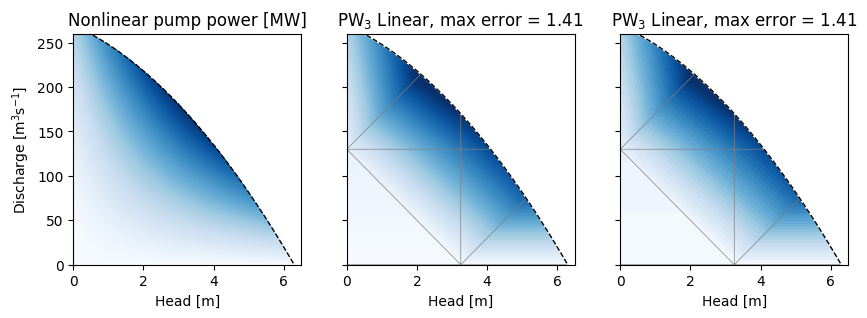

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

max_p = 7.5
ax[0].contourf(dh_grid, q_grid, power_grid_ma, levels=100, cmap='Blues', vmin=0, vmax=max_p)
ax[0].plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
ax[0].set_xlabel('Head [m]')
ax[0].set_ylabel('Discharge [m$^3$s$^{-1}$]')
ax[0].set_title('Nonlinear pump power [MW]')
ax[0].set_ylim(0, 260)

ax[1].contourf(dh_grid, q_grid, y_interp, levels=100, cmap='Blues', vmin=0, vmax=max_p)
ax[1].plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
interp_err = np.round(np.max(np.abs(y_interp - power_grid_ma)), decimals=2)
ax[1].set_xlabel('Head [m]')
ax[1].set_title('PW$_{}$ Linear, max error = {}'.format(n_boxes, interp_err))
ax[1].set_ylim(0, 260)

# Plot the triangulation too
ax[1].triplot(points[:, 0], points[:, 1], tri.simplices, color='grey', lw=0.5)
ax[1].fill_between(dh, 260, QH_pump(dh), color='white')

ax[2].contourf(dh_grid, q_grid, manual_yfit, levels=100, cmap='Blues', vmin=0, vmax=max_p)
ax[2].plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
interp_err = np.round(np.max(np.abs(manual_yfit - power_grid_ma)), decimals=2)
ax[2].set_xlabel('Head [m]')
ax[2].set_title('PW$_{}$ Linear, max error = {}'.format(n_boxes, interp_err))
ax[2].set_ylim(0, 260)

# Plot the triangulation too
ax[2].triplot(points[:, 0], points[:, 1], tri.simplices, color='grey', lw=0.5)
ax[2].fill_between(dh, 260, QH_pump(dh), color='white')


Text(0.7, 0.9, 'Infeasible region')

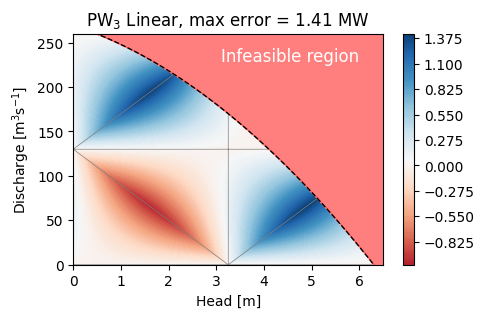

In [96]:
error = manual_yfit - power_grid_ma
error = np.ma.masked_where(q_grid > qh_grid, error)


fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=True)

cbar = fig.colorbar(ax.contourf(dh_grid, q_grid, error, levels=100, cmap='RdBu', vmin=-np.floor(interp_err*10)/10, vmax=np.ceil(interp_err*10)/10))
ax.plot(dh, QH_pump(dh), color='k', ls='--', lw=1)
ax.set_xlabel('Head [m]')
ax.set_ylabel('Discharge [m$^3$s$^{-1}$]')
ax.set_title('PW$_{}$ Linear, max error = {} MW'.format(n_boxes, interp_err))
ax.set_ylim(0, 260)

# Plot the triangulation too
ax.triplot(points[:, 0], points[:, 1], tri.simplices, color='grey', lw=0.5)
ax.fill_between(dh, 260, QH_pump(dh), color='white')
ax.fill_between(dh, 260, QH_pump(dh), color='red', alpha=0.5)
ax.text(0.7, 0.9, 'Infeasible region', transform=ax.transAxes, color='white', fontsize=12, ha='center', va='center')



In [69]:
abs(manual_yfit - y_interp).max()

4.440892098500626e-15

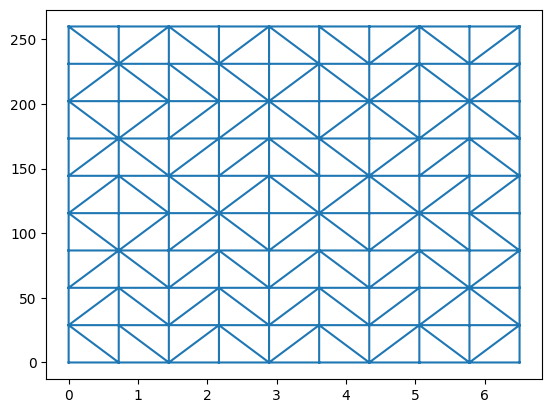

In [99]:
plt.triplot(points[:,0], points[:,1], tri.simplices)